# Ejercicio de Numpy + Matplotlib: La regresión lineal

Ahora que ya hemos explorado las funcionalidades de Numpy vamos a resolver un problema clásico de machine learning: la regresión lineal. Comencemos, como siempre, importando las bibliotecas básicas que vamos a usar:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Para realizar el ejercicio, lo siguiente será descargarnos los datos que vamos a utilizar.

Los datos los obtendremos de [aquí](http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex2/ex2.html): se trata de un ejercicio de la Open Classroom de la Universidad de Stanford sobre cómo hacer una regresión lineal. El ejercicio forma parte de uno de los cursos creados por Andrew Ng.

Andrew es uno de los fundadores de Coursera, y probablemente la figura más conocida en el mundo del aprendizaje automático. Su curso de Machine Learning de Coursera es el más famoso del mundo, y recomiendo encarecidamente echarle un vistazo.

Si miramos el link, veremos que nos ofrece descargar el dataset para poder realizar el ejercicio. En el curso, Andrew recomienda utilizar MATLAB u Octave para hacer los ejercicios. No obstante, estamos con Python, y será lo que utilizaremos para resolverlo.

Si descargamos el archivo .zip, lo guardamos en nuestro ordenador y lo extraemos, podremos ver que son dos archivos: uno con las coordenadas $x$ de una serie de puntos, y otro con las coordenadas $y$. Si mezclamos una a una las líneas de ambos archivos, obtendremos los puntos, es decir: el primer número del archivo de las $x$ junto con el primer número del archivo de las $y$, nos da el primer punto de nuestro dataset, y así sucesivamente. Son 50 puntos en total.

Podríamos hacer justo eso: descargar el .zip manualmente, mover los dos archivos extraídos a una carpeta, y leerlos desde ahí con Python. No obstante, la biblioteca estándar de Python nos permite hacer todos estos pasos directamente programando, y como estamos en el módulo de Python... Vamos a intentar hacerlo así: todo desde Python.

## Descarga del dataset desde Python

El primer paso es descargar el archivo .zip desde Python. Pues bien, resulta que existen varias bibliotecas que nos permiten hacer esto. En este caso vamos a utilizar [urllib](https://docs.python.org/3/library/urllib.html#module-urllib) de la biblioteca estándar. `urllib` es una biblioteca que hace justo lo que sugiere su nombre: gestionar conexión con Internet, siempre y cuando utilicemos urls. Podríamos utilizar `Requests` también para hacerlo, pero quería añadir variedad...

Resulta que `urllib.request` nos ofrece una función llamada [`urlretrieve`](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve), la cual vamos a utilizar para descargar el archivo zip. Al llamar a la función y pasarle como argumento la url del archivo a descargar, nos devuelve una tupla con dos elementos: uno es la ruta donde se ha descargado el archivo (puesto que al llamar a la función, se lo descarga automáticamente en una carpeta temporal del sistema operativo). El otro es la información del resultado de dicha descarga del archivo:

In [2]:
from urllib.request import urlretrieve
datos, respuesta = urlretrieve("http://openclassroom.stanford.edu/MainFolder/courses/MachineLearning/exercises/ex2materials/ex2Data.zip")

Hemos utilizado una asignación doble de variables (lo que se llama [*tuple unpacking*](https://www.youtube.com/watch?v=m91jfl7JYLk)), para poder asignar ambas en una sola línea. `respuesta` es la información del resultado de la descarga; y `datos` es un string que nos dice la ubicación del .zip descargado:

In [3]:
print(respuesta)
print("")
print("Archivo descargado en: " + datos)

Date: Wed, 14 Jul 2021 11:15:07 GMT
Server: Apache/2.2.15 (CentOS)
Last-Modified: Tue, 28 Dec 2010 22:06:34 GMT
ETag: "726c14c8-351-4987faa672e80"
Accept-Ranges: bytes
Content-Length: 849
Connection: close
Content-Type: application/zip



Archivo descargado en: /var/folders/fm/05lsctd57gg86jcr1y1_bv5xth0pg5/T/tmpuywuo2bc


Ya tenemos nuestro archivo .zip descargado; ahora tenemos que descomprimir el zip. Podemos hacerlo fácilmente con la bilbioteca estándar de Python, gracias a [zipfile](https://docs.python.org/2/library/zipfile.html).

## Descompresión del .zip y rutas del sistema operativo

Python nos ofrece en la bilbioteca estándar un módulo llamado [`os`](https://docs.python.org/3/library/os.html#module-os). Dicho módulo nos permite realizar muchas cosas relacionadas con nuestro sistema operativo. Un ejemplo de lo que podemos hacer con `os` es movernos por los directorios de nuestro ordenador, tal y como haríamos a golpe de ratón y haciendo click en carpetas... Solo que desde Python.

[`os.path.abspath`](https://docs.python.org/3/library/os.path.html#os.path.abspath) nos da la ruta completa de un directorio; mientras que [`os.curdir`](https://docs.python.org/3/library/os.html#os.curdir) nos da "el directorio donde está Python actualmente".

Python, a ojos de nuestro sistema operativo, es un proceso. Dicho proceso se inicia en algún directorio (o carpeta). Si nos vamos a una terminal (o cmd.exe), tecleamos `python` y pulsamos Enter, se iniciará un proceso de Python, en la ruta desde la que hemos tecleado dicha sentencia. Desde ahí, podemos utilizar `os` para que nuestro proceso Python se "mueva" por las carpetas de nuestro ordenador.

Puesto que estamos en un notebook, puede resultar menos obvio saber "en qué directorio está nuestro proceso de Python ahora mismo". Para eso utilizamos `os.path.abspath(os.curdir)`, para preguntárselo. Una vez que lo sabemos, podremos continuar:

In [4]:
import os

directorio_actual = os.path.abspath(os.curdir)

print("El directorio en el que está Python ahora mismo es " + directorio_actual)

El directorio en el que está Python ahora mismo es /Users/nfrate/Desktop/DATAHACK/Documentación-20210621/Entrega Final


`directorio_actual` es un string con dicho directorio (ruta). Y tenemos la ruta de nuestro .zip descargado en la variable `datos`. Así que vamos a utilizar la bilbioteca [`zipfile`](https://docs.python.org/3/library/zipfile.html#module-zipfile) (también de la biblioteca estándar) para extraer los datos del .zip, y guardarlos en nuestro directorio actual.

Para hacerlo, primero vamos a leer el archivo de la forma normal en la que lo hacemos en Python, con `open()`, y en este caso en el modo `rb` (read binary). Con el archivo abierto, aplicamos `zipfile.ZipFile(archivo)` para decirle a Python que el archivo es un .zip (creando una instancia de la clase `ZipFile`).

Hecho esto, podemos aplicar el método `.printdir()` para imprimir los contenidos del zip. Vemos que, efectivamente, son dos: uno con los datos de las $x$ y otro con los datos de las $y$.

Tras verlo, aplicamos `.extractall(directorio)` para extraer los archivos en el directorio que queramos. Como queremos hacerlo en "el directorio actual de Python", le pasamos dicha variable:

In [5]:
import zipfile

archivo_zip = open(datos, "rb")

archivo_zip_instanciado = zipfile.ZipFile(archivo_zip)
archivo_zip_instanciado.printdir()
archivo_zip_instanciado.extractall(directorio_actual)

# ¡Nunca olvides cerrar los archivos leídos!
archivo_zip.close()

File Name                                             Modified             Size
ex2x.dat                                       2010-10-14 10:57:02          850
ex2y.dat                                       2010-10-14 10:57:02          850


Ya están los datos extraídos. Podemos irnos al navegador de carpetas de nuestro sistema operativo y verlos si queremos: ahí están. 

Ahora vamos a usar [`os.path.join`](https://docs.python.org/3/library/os.path.html#os.path.join) nos permite concatenar rutas. Es decir: supongamos que tenemos un directorio:

`/sistema/usuario`

Y dentro de esa carpeta `usuario`, un archivo llamado `hola.txt`. Pues bien, a pocos conocimientos que tengamos de sistemas operativos, sabremos que la ruta absoluta de `hola.txt` será algo como:

`/sistema/usuario/hola.txt`

No obstante, `os.path.join()` nos permite hacer esto de forma segura; sin que nos equivoquemos. ¿Por qué? Porque las rutas son muy distintas en los distintos sistemas operativos. Por ejemplo: las barras para indicar un cambio de directorio en Windows son `\`, mientras que en Linux y Mac son al revés: `/`

Para evitar este tipo de problemas, y que el código sea portable y compartible entre plataformas, podemos utilizar `os.path.join()`, para que Python se encargue automáticamente de unir "con la barrita adecuada" las rutas:

In [6]:
ruta_archivo_x = os.path.join(directorio_actual, "ex2x.dat")
ruta_archivo_y = os.path.join(directorio_actual, "ex2y.dat")
print(ruta_archivo_x)
print(ruta_archivo_y)

/Users/nfrate/Desktop/DATAHACK/Documentación-20210621/Entrega Final/ex2x.dat
/Users/nfrate/Desktop/DATAHACK/Documentación-20210621/Entrega Final/ex2y.dat


Ahora `ruta_archivo_x` y `ruta_archivo_y` son las rutas absolutas de los dos archivos descargados. Ya podemos leerlos fácilmente con Python. Para leer cada archivo del tirón, y que cree una lista con cada línea del archivo como un elemento de la misma, poedmos utilizar `archivo.readlines()`:

In [7]:
archivo_x = open(ruta_archivo_x, "r")
x_leido = archivo_x.readlines()
archivo_x.close()

archivo_y = open(ruta_archivo_y, "r")
y_leido = archivo_y.readlines()
archivo_y.close()
    
# Vamos a imprimir unos cuantos elementos
# de la lista x_leido:
print(x_leido[:10])

['   2.0658746e+00\n', '   2.3684087e+00\n', '   2.5399929e+00\n', '   2.5420804e+00\n', '   2.5490790e+00\n', '   2.7866882e+00\n', '   2.9116825e+00\n', '   3.0356270e+00\n', '   3.1146696e+00\n', '   3.1582389e+00\n']


## Limpieza y transformación de los datos

Podemos ver que el formato de los números es extraño, y que tenemos unos cuantos espacios antes de que empiece cada número; y al final de cada uno tenemos el caracter de salto de línea `\n`. Cada elemento de la lista es de momento un string, y debemos:
+ Limpiar esos espacios y caracteres `\n`
+ Convertirlos a `float`s

Para la limpieza, podemos utilizar el método `.strip()` sobre cada string, el cual nos hace automáticamente esa limpieza. Es muy similar al método `.trim()` de Java, el cual hace básicamente la misma limpieza. [Aquí](https://docs.python.org/2/library/string.html#string.strip) puedes leer sobre `.strip()`.

Para convertir los números a `float`s, simplemente hacemos `float(el_string_limpio)`. Python es muy listo, y sabe leer bien la notación exponencial de los números.

Podemos realizar las dos transformaciones de cada elemento de cada lista utilizando una *list comprehension*. Vamos a hacerlo:

In [8]:
x = [float(elemento.strip()) for elemento in x_leido]
y = [float(elemento.strip()) for elemento in y_leido]

# Comprobamos:
print(x[:10])
print(y[:10])

[2.0658746, 2.3684087, 2.5399929, 2.5420804, 2.549079, 2.7866882, 2.9116825, 3.035627, 3.1146696, 3.1582389]
[0.77918926, 0.91596757, 0.90538354, 0.90566138, 0.9389889, 0.9668474, 0.96436824, 0.91445939, 0.93933944, 0.96074971]


Parece que todo ha salido bien: ya tenemos dos listas, `x` e `y`, con los datos descargados, limpios y en formato decimal. Podemos eliminar los archivos descomprimidos de nuestro ordenador. En el caso de que algo salga mal, no tenemos más que volver a ejecutar las celdas del Notebook, y se realizará todo el proceso de descarga, extracción y limpieza de los datos de forma automática.

Para borrar los archivos de nuestro ordenador, podemos utilizar [`os.remove(la_ruta_del_archivo_a_borrar)`](https://docs.python.org/3/library/os.html#os.remove):

In [9]:
os.remove(ruta_archivo_x)
os.remove(ruta_archivo_y)

## La regresión lineal con Numpy

Por fin podemos empezar a utilizar Numpy.

El primer paso es sencilo: convertir las listas de Python a arrays de Numpy. A ello:

In [10]:
# Ejercicio01: convertir las listas x e y
# a arrays de Numpy:

array_x = np.array(x)
array_y = np.array(y)

print("Primeras líneas de cada array:")
print("x: \n" + str(array_x[:10]))
print("y: \n" + str(array_y[:10]))

Primeras líneas de cada array:
x: 
[2.0658746 2.3684087 2.5399929 2.5420804 2.549079  2.7866882 2.9116825
 3.035627  3.1146696 3.1582389]
y: 
[0.77918926 0.91596757 0.90538354 0.90566138 0.9389889  0.9668474
 0.96436824 0.91445939 0.93933944 0.96074971]


In [11]:
# Test01
assert np.allclose(np.array([array_x.sum()]), np.array([246.17859859999999])), "Test fallido: array_x"
assert np.allclose(np.array([array_y.sum()]), np.array([53.234302730000003])), "Test fallido: array_y"
print("¡Correcto!")

¡Correcto!


Tenemos las coordenadas de las $x$ en un array unidimensional de longitud 50 (la variable que hemos llamado `array_x`); y las coordenadas de las $y$ en otro array igual (`array_y`).

No obstante, no es lo mismo un array unidimensional de longitud $50$, que un array de dimensiones $50 \times 1$. Para continuar con el ejercicio, nos va a ser más conveniente hacer dicha conversión. Podemos hacerlo sencillamente aplicando el método `.reshape()` a ambos arrays:

In [12]:
# Ejercicio02: redimensionar los arrays,
# para que dejen de ser de dimensiones (50,)
# y pasen a ser (50,1):

array_x_redimen = array_x.reshape(50,1)
array_y_redimen = array_y.reshape(50,1)

print("Primeras líneas de cada array:")
print("x: \n" + str(array_x_redimen[:10]))
print("y: \n" + str(array_y_redimen[:10]))

Primeras líneas de cada array:
x: 
[[2.0658746]
 [2.3684087]
 [2.5399929]
 [2.5420804]
 [2.549079 ]
 [2.7866882]
 [2.9116825]
 [3.035627 ]
 [3.1146696]
 [3.1582389]]
y: 
[[0.77918926]
 [0.91596757]
 [0.90538354]
 [0.90566138]
 [0.9389889 ]
 [0.9668474 ]
 [0.96436824]
 [0.91445939]
 [0.93933944]
 [0.96074971]]


In [13]:
array_x_redimen.reshape(-1,1).shape

(50, 1)

In [14]:
# Test02
assert array_x_redimen.shape == (50,1), "Error en las dimensiones de array_x_redimen"
assert array_y_redimen.shape == (50,1), "Error en las dimensiones de array_y_redimen"
print("¡Correcto!")

¡Correcto!


Ahora ya podemos concatenar ambos arrays, para obtener una matriz con las coordenadas de cada uno de los cincuenta puntos que componen nuestro dataset. Para hacerlo, debemos utilizar la función `np.concatenate`. ¡Manos a la obra!

In [15]:
# Ejercicio03: concatenar los arrays x e y en una matriz
# a la que llamaremos dataset, cuyas dimensiones han 
# de ser 50 x 2.

dataset = np.concatenate((array_x_redimen.reshape(-1,1),array_y_redimen.reshape(-1,1)),axis=1).reshape(50,2)
print("Dataset (columna x, columna y):\n" + str(dataset[:10]))

Dataset (columna x, columna y):
[[2.0658746  0.77918926]
 [2.3684087  0.91596757]
 [2.5399929  0.90538354]
 [2.5420804  0.90566138]
 [2.549079   0.9389889 ]
 [2.7866882  0.9668474 ]
 [2.9116825  0.96436824]
 [3.035627   0.91445939]
 [3.1146696  0.93933944]
 [3.1582389  0.96074971]]


In [16]:
# Test03
assert dataset.shape == (50,2), "Error en las dimensiones de la matriz."
assert np.allclose(dataset.sum(axis=0), np.array([246.1785986, 53.23430273])), ("Test fallido: matriz. Comprueba que la primera columna es la de las x y la segunda la de las y")
print("¡Correcto!")

¡Correcto!


Vamos a comenzar por hacer un gráfico de dispersión (scatterplot) de los datos, para ver qué pinta tienen. Podríamos hacerlo tal y como hemos visto, con `plt.plot()`, pero existe una forma más sencilla (y muy similar) de hacer gráficos de dispersión: `plt.scatter()`. Admite prácticamente los mismos argumentos que `plt.plot()`: primero los datos del eje x, luego los del y, y en este caso vamos a utilizar el argumento `s=tamaño` para darle un tamaño de 50 a los puntos de nuestro gráfico.

Para separar los datos de los ejes x e y a partir de nuestro `dataset`, podemos hacerlo con slicing, tal y como aparece en la teoría.

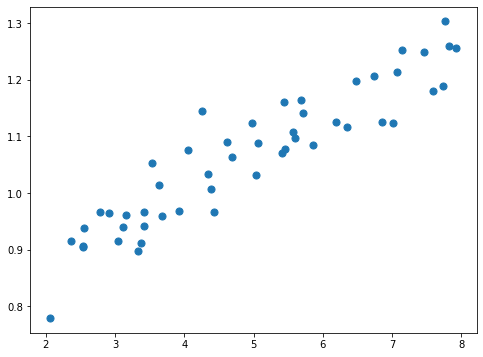

In [17]:
# Ejercicio04: rellenar con los datos de los ejes
# x e y a partir de nuestro dataset haciendo slicing.
# Así, podrás dibujar con plt.scatter:
plt.figure(figsize=(8,6))

# Para más información sobre plt.scatter, consultar:
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter
plt.scatter(dataset[:,:1], dataset[:,1:2], s=50)

Si miramos en la [web del ejercicio](http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex2/ex2.html) y vamos al gráfico, veremos que lo hemos dibujado bien y que tiene la misma pinta (con otra herramienta distinta, pero el resultado debe ser el mismo evidentemente).

A estas alturas ya merece la pena explicar el dataset. Cada punto del gráfico que acabamos de hacer es una observación. En el eje de las $x$, tenemos la edad de distintos niños tomados de una muestra. En el eje $y$, tenemos su altura en metros. De forma que si miramos el primer punto en el gráfico (el que está más abajo a la izquierda), podemos ver que se trata de un niño de unos dos años de edad que mide algo menos de ochenta centímetros (0,8m). Vamos a realizar una regresión lineal para crear un modelo predictivo con el que intentemos predecir la altura de un niño, dada su edad.


Una vez que tenemos el `dataset` en una matriz, vamos a comenzar con una poca teoría sobre la regresión lineal.

Lo que vamos a hacer en el ejercicio es la regresión lineal simple univariante, utilizando el método de Mínimos Cuadrados Ordinarios (OLS en inglés). Se trata de un modelo muy simple, que nos permitirá predecir valores de $y$ (altura) dados nuevos valores de $x$ (edad).

El modelo de OLS tiene una particularidad muy importante. A diferencia de la mayoría de algoritmos de machine learning, que son iterativos, OLS tiene lo que se llama una *closed form solution*: una solución cerrada, que siempre es la misma, y a la que podemos llegar sin necesidad de realizar iteraciones sobre nuestro dataset (es decir, sin bucles `for` ni similares). La explicación matemática de por qué OLS tiene esta solución cerrada es aburrida, pero básicamente dice que la función de reducción (*loss function* en inglés) es convexa, de forma que la optimización de la misma se puede realizar de forma determinística y, en este caso, utilizando sencillo álgebra lineal.

Formulemos el problema: tenemos nuestra variable, columna, matriz o vector $X$, que representa la edad de los niños en este caso. Tenemos 50 observaciones, así que $N$ (letra que se suele utilizar como número de observaciones) es $50$:

$$X = \begin{bmatrix}x_{observacion 1}\\x_{observacion 2}\\x_{observacion 3}\\\vdots\\x_{observacion N}\end{bmatrix}$$

Donde $x_{observacion 1}$ (o simplemente $x_1$) es la edad de la primera observación (primer niño), $x_2$ la del segundo niño, etcétera.

También tenemos la altura de los niños $y$, que en este caso es *lo que vamos a querer predecir*, por lo que será nuestra variable dependiente, variable objetivo o *target variable*:

$$y = \begin{bmatrix}y_{observacion1}\\y_{observacion2}\\y_{observacion3}\\\vdots\\y_{observacionN}\end{bmatrix}$$

Lo que nosotros queremos obtener es una *ley* (una función para ser más precisos) que nos permita explicar la $y$ en función de la $x$, mediante la multiplicación por un parámetro $\beta$, que es realmente lo que tenemos que estimar:

$$y = \beta \cdot X$$

Bueno, pues resulta que en el caso de OLS, podemos obtener este parámetro $\beta$ a través de la siguiente expresión:

$$\beta = (X^{T}X)^{-1}X^{T}y$$

Así que para obtener $\beta$, solo tenemos que realizar las operaciones de álgebra lineal mostradas. El resultado, en este caso, será un número para $\beta$ (más sobre eso luego). Vamos a ello:

In [18]:
# Por temas de sencillez, vamos a re-asignar a la
# variable X la columna de las xs de nuestro dataset;
# y la variable y a la columna de las ys:
X = dataset[:,0].reshape(50,1)
y = dataset[:,1].reshape(50,1)

print("X (primeras 10 observaciones):\n" + str(X[:10])+"\n")
print("y (primeras 10 observaciones):\n" + str(y[:10]))

X (primeras 10 observaciones):
[[2.0658746]
 [2.3684087]
 [2.5399929]
 [2.5420804]
 [2.549079 ]
 [2.7866882]
 [2.9116825]
 [3.035627 ]
 [3.1146696]
 [3.1582389]]

y (primeras 10 observaciones):
[[0.77918926]
 [0.91596757]
 [0.90538354]
 [0.90566138]
 [0.9389889 ]
 [0.9668474 ]
 [0.96436824]
 [0.91445939]
 [0.93933944]
 [0.96074971]]


Siguiendo la formula, los calculos serian:  

Primer termino:  

- producto matricial entre la transpuesta de X y X --> `np.dot(X.T,X)`
- luego aplicar la inversa del paso anterior --> `np.linalg.inv(np.dot(X.T,X)`

Segundo termino:  

- producto matricial entre la transpuesta de X e y --> `np.dot(X.T,y)`

ultimo paso:  

- producto matricial entre la matriz resultante del primer termino y segundo termino --> `np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,y))`

In [19]:
# Ejercicio05: Realizar el cómputo de
# beta, a partir de la fórmula de la
# closed form solution para OLS,
# dados X e y:


beta = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,y))

print("Beta:\n" + str(beta))

Beta:
[[0.19984032]]


In [20]:
# Test05
assert np.allclose(beta, np.array([[0.19984032]])), "Error: valor inválido de beta"
print("Correcto!")

Correcto!


Si antes formulamos que:
$$y = \beta \cdot X$$
Y ya tenemos $\beta$, podemos escribir nuestra *función hipótesis*, o modelo:

In [21]:
beta

array([[0.19984032]])

In [22]:
# Ejecutar esta celda:
beta = beta[0,0]
print("Hipótesis:\n" + "y = " + str(beta) + " x")

Hipótesis:
y = 0.1998403198941999 x


En la regresión lineal univariante, vemos que el resultado no es más que una función de una recta. Ya sabemos dibujar eso en Matplotlib: de hecho, vamos a dibujar el scatterplot y la función de nuestra recta en el mismo gráfico:

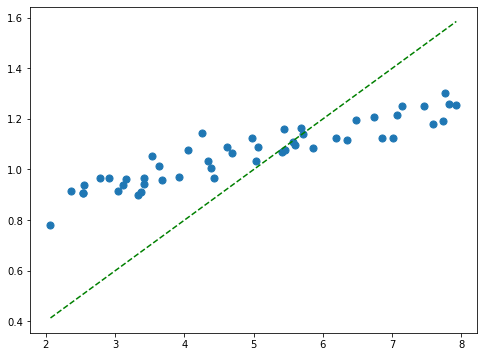

In [23]:
# Ejercicio06: dibujar el scatterplot
# de nuevo, mas nuestra funcion de la recta:
plt.figure(figsize=(8,6))

# Primero el scatterplot (igual que el anterior,
# con los mismos datos en cada eje):
plt.scatter(X, y, s=50)

# Y ahora la recta:
plt.plot(X, X*beta,"g--") # g-- = Linea verde con rayitas

¡Vaya! Parece que nuestra recta no capta demasiado bien la tendencia de los datos. Debería estar probablemente más "encima de ellos", y su inclinación debería ajustarse más a la tendencia creciente de la altura con la edad de los niños. Algo está pasando...

Bueno: resulta que en casi todos los modelos lineales de machine learning, existe una variable que merece la pena incluir en nuestro dataset. Dicha variable se llama sesgo, *bias* o *intercept*. En nuestra función hemos estimado el número para $\beta$:

$$y = \beta \cdot X$$

Que multiplica a nuestras $X$. No obstante, si sabemos algo de geometría, podemos ver que nuestra recta no tiene ordenada en en origen, es decir, que sale desde en punto (0,0) del eje de coordenadas (aunque no sea muy evidente en el gráfico anterior, es así).

El *bias* es básicamente eso: añadir la ordenada en el origen a nuestro modelo a resolver. ¿Cómo podemos hacer esto? Bueno, resulta que la notación de $X$ mayúscula, $y$ minúscula y $\beta$ minúscula (aunque no lo parezca), no era capricho. En notación algebraica:

+ Las letras latinas mayúsculas se suelen utilizar para matrices conocidas.
+ Las letras latinas minúsculas se suelen utilizar para escalares o vectores conocidos.
+ Las letras griegas mayúsculas se suelen utilizar para matrices desconocidas, o a estimar.
+ Las letras griegas minúsculas se suelen utilizar para escalares o vectores desconocidos, o a estimar.

¿Cómo añadimos el *bias*? Bueno, supongamos por un momento que nuestra matriz $X$ tiene $N$ filas y $M$ columnas, donde cada columna es una variable distinta (además de edad, supongamos peso, longitud de los dedos, longitud de las piernas... así hasta $M$ variables), y cada fila una observación distinta:

$$X = \begin{bmatrix}x_{11} & x_{12} & x_{13} & \dots & x_{1M}\\x_{21} & x_{22} & x_{23} & \dots & x_{2M}\\ x_{31} & x_{32} & x_{33} & \dots & x_{3M}\\\vdots & \vdots & \vdots & \ddots & \vdots\\x_{N1} & x_{N2} & x_{N3} &  \dots & x_{NM}\end{bmatrix}$$

Haciendo esto, lo que antes era únicamente $N$ observaciones de una variable, ahora serían $N$ observaciones de $M$ variables; y a todo eso le llamamos nuestra *feature matrix* $X$.

¿Qué vamos a hacer con el *bias*? Añadirlo como una segunda variable. Normalmente esto se hace cambiando un poco la notación sobre la mostrada en la matriz de arriba. Al *bias* se la suele llamar como variable/columna $0$, es decir, empezando a contar las columnas desde $0$ en vez de desde $1$. Entonces, nuestra *feature matrix* $X$ específica para este problema (donde hasta ahora solo teníamos la variable/columna edad) quedaría así:

$$X = \begin{bmatrix}x_{10} & x_{11}\\x_{20} & x_{21}\\ x_{30} & x_{31}\\\vdots & \vdots \\x_{N0} & x_{N1}\end{bmatrix}$$

Donde la columna $0$ será nuestra variable *bias*, y la columna $1$ nuestra variable edad.

Bueno, ¿y qué valores tendrá la columna $0$? En la literatura podrás ver que para añadir el *bias* se suele generar una columna de todo unos (por razones que veremos luego). Una ocasión magnífica para utilizar `np.ones()`. De forma que será:

$$X = \begin{bmatrix}1 & x_{11}\\1 & x_{21}\\1 & x_{31}\\\vdots & \vdots \\1 & x_{N1}\end{bmatrix}$$

Resulta que el resto de nuestra notación apenas cambia. Comprobémoslo. Teníamos:

$$y = \beta \cdot X$$

Y para calcular $\beta$:

$$\beta = (X^{T}X)^{-1}X^{T}y$$



Donde ahora:

+ $X$ es una matriz $50 \times 2$
+ $y$ sigue siendo una sola columna: $50 \times 1$

Si hacemos algo de cálculo algebraico a ojo, veremos que $\beta$ quedará como una matriz de dimensiones $2 \times 1$:

$$\beta = \begin{bmatrix}\beta_{0}\\\beta_{1}\end{bmatrix}$$

De forma que ahora que el parámetro $\beta$ no es un único número, sino un vector con dos valores. Escrito en forma de ecuación de recta, será, para una fila/observación $i$ cualquiera del dataset:

$$y_i = \beta_0 \cdot x_{i0} + \beta_1 \cdot x_{i1}$$

Y gracias a que la columna de la *feature matrix* $X$ son todo unos (en todas las observaciones), podemos sustituir por unos: 

$$y_i = \beta_0 \cdot 1 + \beta_1 \cdot x_{i1}$$

Y si lo ordenamos un poquito:

$$y_i =  \beta_1 \cdot x_{i1} + \beta_0$$

Y si la ponemos de forma general (quitando las $i$s que indican la fila), y el subíndice 1 de las $x$ (puesto que tenemos solo una variable dada en este caso, edad):

$$y =  \beta_1 \cdot x + \beta_0$$

Conclusión: añadiendo un *bias*, obtenemos una nueva fórmula de nuestra recta, ahora con ordenada en el origen $\beta_0$; lo cual nos va a ofrecer un mejor ajuste en nuestro modelo. A toda esta operación de añadir una columna de unos a nuestra *feature matrix* se le suele llamar *añadir threshold o intercept* al modelo. Así lo veremos cuando utilicemos Scikit-Learn (que llama a esta columna de unos *intercept*). 

Siempre que nuestros datos no estén centrados (es decir, que no tengan media 0), se recomienda añadir *intercept*, para un mejor ajuste.

Puede parecer complicado, pero en definitiva: solo tenemos que añadir una columna de unos a nuestro dataset, y realizar las mismas operaciones algebraicas para sacar nuestro, ahora, vector $\beta$.

Recordemos que tenemos definida una variable `X`, que son las observaciones de edad:

In [24]:
# Ejecutar para ver las primeras 10 observaciones de nuestra feature matrix X:
X[:10]

array([[2.0658746],
       [2.3684087],
       [2.5399929],
       [2.5420804],
       [2.549079 ],
       [2.7866882],
       [2.9116825],
       [3.035627 ],
       [3.1146696],
       [3.1582389]])

Y nuestro vector `y`:

In [25]:
# Ejecutar para ver las primeras 10 observaciones de y:
y[:10]

array([[0.77918926],
       [0.91596757],
       [0.90538354],
       [0.90566138],
       [0.9389889 ],
       [0.9668474 ],
       [0.96436824],
       [0.91445939],
       [0.93933944],
       [0.96074971]])

Vamos a crear una nueva variable llamada `X_con_intercept`, añadiendo una columna de unos sobre nuestra antigua *feature matrix* $X$. Lo haremos con `np.ones((filas, columnas))`, y luego con un `np.concatenate()`:

In [26]:
# Ejercicio07: añadir una columna de
# unos en nuestra feature matrix X:
columna_unos = np.ones((50,1))

X_con_intercept = np.concatenate((columna_unos,X),axis=1)

print(X_con_intercept[:10])

[[1.        2.0658746]
 [1.        2.3684087]
 [1.        2.5399929]
 [1.        2.5420804]
 [1.        2.549079 ]
 [1.        2.7866882]
 [1.        2.9116825]
 [1.        3.035627 ]
 [1.        3.1146696]
 [1.        3.1582389]]


In [27]:
# Test07
assert X_con_intercept.shape == (50,2), "Error: las dimensiones de X_con_intercept están mal. Debería ser una matriz 50 x 2"
assert np.allclose(X_con_intercept.sum(axis=0), np.array([50. , 246.1785986])), "Error: matriz X_con_intercept no válida. ¿Seguro que has añadido la columna de unos, y ésta es la primera de todas?"
print("Correcto!")

Correcto!


Ahora ya tenemos nuestro *feature matrix* $X$ con la columna *bias*/*intercept* de unos. Ya podemos volver a calcular:

$$\beta = (X^{T}X)^{-1}X^{T}y$$

In [28]:
# Ejercicio08: calcular el nuevo vector beta,
# donde nuestra matriz X es la X_con_threshold
# que acabamos de hacer:

beta = np.dot(np.linalg.inv(np.dot(X_con_intercept.T,X_con_intercept)),np.dot(X_con_intercept.T,y))

print("Vector beta:\n" + str(beta))

Vector beta:
[[0.75016254]
 [0.06388117]]


In [29]:
# Test08
assert beta.shape == (2,1)
assert np.allclose(beta, np.array([[0.75016254],[0.06388117]]))
print("¡Correcto!")

¡Correcto!


Ya tenemos nuestra nueva estimación de parámetros del vector $\beta$. Si lo ponemos en nuestra ecuación de la recta:

In [30]:
# Por motivos de simplicidad,
# vamos a separar los dos valores
# del vector en beta_0 (threshold/bias)
# y beta_1 (parámetro que multiplica a la edad).
# Ejecuta esta celda para hacerlo:
beta_0 = beta[0,0]
beta_1 = beta[1,0]
print("Nuestra función ahora es:")
print("y = " + str(beta_1) + " x + " + str(beta_0))

Nuestra función ahora es:
y = 0.06388116582583336 x + 0.750162537001243


Y este es nuestro nuevo modelo. Vamos a dibujar de nuevo el scatterplot, y la nueva recta:

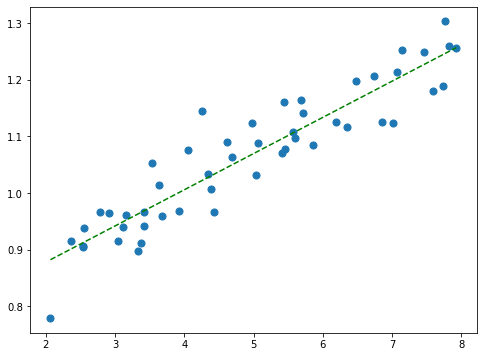

In [31]:
# Ejercicio09: dibujar de nuevo el scatterplot
# y la nueva recta:
plt.figure(figsize=(8,6))

# Como en los anteriores, primero el scatterplot:
plt.scatter(X, y, s=50)

# Y ahora la nueva recta
plt.plot(X, X*beta_1 + beta_0,"g--")



Gracias que hemos añadido el *intercept* nuestra recta ahora tiene ordenada en el origen; y el ajuste es mucho mejor como podemos ver.